In [1]:
import math
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as ss
from collections import Counter
from mlxtend.evaluate import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

### import  train,test, and label dataset

In [2]:
train = pd.read_csv("D:/Semester 7/Ml_Project/Training_set_values.csv")
test = pd.read_csv("D:/Semester 7/Ml_Project/Test_set_values.csv")
train_label = pd.read_csv("D:/Semester 7/Ml_Project/Training_set_labels.csv")

In [3]:
train.head(10)

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
5,9944,20.0,2011-03-13,Mkinga Distric Coun,0,DWE,39.172796,-4.765587,Tajiri,0,...,per bucket,salty,salty,enough,enough,other,other,unknown,communal standpipe multiple,communal standpipe
6,19816,0.0,2012-10-01,Dwsp,0,DWSP,33.362410,-3.766365,Kwa Ngomho,0,...,never pay,soft,good,enough,enough,machine dbh,borehole,groundwater,hand pump,hand pump
7,54551,0.0,2012-10-09,Rwssp,0,DWE,32.620617,-4.226198,Tushirikiane,0,...,unknown,milky,milky,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump
8,53934,0.0,2012-11-03,Wateraid,0,Water Aid,32.711100,-5.146712,Kwa Ramadhan Musa,0,...,never pay,salty,salty,seasonal,seasonal,machine dbh,borehole,groundwater,hand pump,hand pump
9,46144,0.0,2011-08-03,Isingiro Ho,0,Artisan,30.626991,-1.257051,Kwapeto,0,...,never pay,soft,good,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump


### plot bar chart for label set

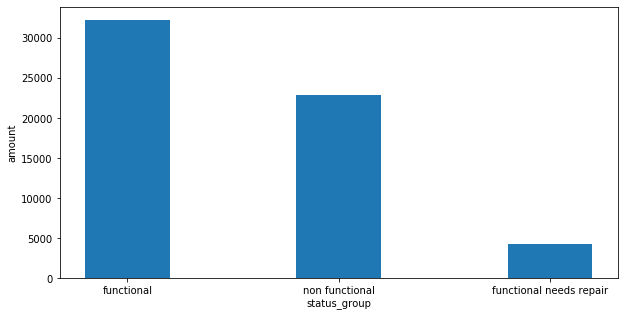

functional: 0.543080808080808
non functional: 0.3842424242424242
functional needs repair: 0.07267676767676767


In [4]:
status_group = train_label['status_group'].value_counts().to_dict()

type_ = list(status_group.keys())
values = list(status_group.values())
  
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(type_, values,
        width = 0.4)
 
plt.xlabel("status_group")
plt.ylabel("amount")
plt.show()

list_value = list(status_group.values())
list_value = [float(i)/sum(list_value) for i in list_value]
list_key = list(status_group.keys())
for i in range(len(list_value)):
    print(str(list_key[i])+": "+str(list_value[i]))

###### therefore dataset is imbalanced

### find duplicate rows


In [5]:
col_except_id = list(train.columns)[1:]

In [6]:
print("Number of duplicated rows in train set: " + str(train.duplicated(subset=col_except_id).sum()))

Number of duplicated rows in train set: 37


In [7]:
duplicate_indexes = train.loc[train.duplicated(subset=col_except_id), :]
duplicate_indexes = list(duplicate_indexes.index)
print(duplicate_indexes)

[7709, 8731, 11260, 13823, 17133, 22080, 22140, 25300, 25928, 28518, 29044, 31558, 34310, 34465, 35920, 36069, 37202, 37439, 37925, 38165, 39187, 40287, 40696, 42650, 44093, 46582, 46845, 46923, 49865, 53060, 53441, 53944, 56268, 56599, 57230, 58463, 58859]


### removing identical rows

In [8]:
print("Number of rows in train set: "+ str(len(train.index)))
print("Number of rows in test set: "+ str(len(test.index)))
print("Number of rows in train labels: "+ str(len(train_label.index)))

Number of rows in train set: 59400
Number of rows in test set: 14850
Number of rows in train labels: 59400


In [9]:
train = train.drop_duplicates(subset=col_except_id)
train_label = train_label.drop(train_label.index[duplicate_indexes])

In [10]:
print("Number of rows in train set after removing duplicates: "+ str(len(train.index)))
print("Number of rows in train label set after removing duplicates: "+ str(len(train_label.index)))

Number of rows in train set after removing duplicates: 59363
Number of rows in train label set after removing duplicates: 59363


### clarify whether identical rows are removed or not

In [11]:
print("Number of duplicated rows in train set: " + str(train.duplicated(subset=col_except_id).sum()))

Number of duplicated rows in train set: 0


### Find columns which contain NaN

In [12]:
train_col_with_NaN = train.columns[train.isna().any()].tolist()
test_col_with_NaN = test.columns[test.isna().any()].tolist()

print("columns which contain NaN in train set: " + str(train_col_with_NaN))
print("columns which contain NaN in test set: " + str(test_col_with_NaN))

columns which contain NaN in train set: ['funder', 'installer', 'subvillage', 'public_meeting', 'scheme_management', 'scheme_name', 'permit']
columns which contain NaN in test set: ['funder', 'installer', 'subvillage', 'public_meeting', 'scheme_management', 'scheme_name', 'permit']


### remove NaN values from identified columns using mode

In [13]:
for col in train_col_with_NaN:
    train[col].fillna(train[col].mode()[0], inplace = True)
    test[col].fillna(test[col].mode()[0], inplace=True)


### clarify whether NaN values are replced

In [14]:
train.columns[train.isna().any()].tolist()
test.columns[test.isna().any()].tolist()

[]

In [15]:
train.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


### Change values less than 25 in funder and installer column to 'others'

In [16]:
counts = train['funder'].value_counts().to_dict()
counts_ = train['installer'].value_counts().to_dict()
for key in counts:
    if (counts[key]<=25):
        train["funder"].replace({key: "others"}, inplace=True)

        
for key in counts_:
    if (counts_[key]<=25):
        train['installer'].replace({key: "others"}, inplace=True)

### Exatract month and year from "date_recorded" column and create new columns called month and year

In [17]:
train['month']=pd.to_datetime(train.date_recorded).dt.month
test['month']=pd.to_datetime(test.date_recorded).dt.month

train['year']=pd.to_datetime(train.date_recorded).dt.year
test['year']=pd.to_datetime(test.date_recorded).dt.year

train = train.drop(['date_recorded'], axis = 1)
test = test.drop(['date_recorded'], axis = 1)
col_except_id.remove('date_recorded')



In [18]:
train.head()

,id,amount_tsh,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,...,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,month,year
0,69572,6000.0,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,...,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,3,2011
1,8776,0.0,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,...,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,3,2013
2,34310,25.0,others,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,...,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,2,2013
3,67743,0.0,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,...,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,1,2013
4,19728,0.0,others,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,...,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,7,2011


In [19]:
test.head()

,id,amount_tsh,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,...,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,month,year
0,50785,0.0,Dmdd,1996,DMDD,35.290799,-4.059696,Dinamu Secondary School,0,Internal,...,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,other,other,2,2013
1,51630,0.0,Government Of Tanzania,1569,DWE,36.656709,-3.309214,Kimnyak,0,Pangani,...,good,insufficient,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe,2,2013
2,17168,0.0,Government Of Tanzania,1567,DWE,34.767863,-5.004344,Puma Secondary,0,Internal,...,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,other,other,2,2013
3,45559,0.0,Finn Water,267,FINN WATER,38.058046,-9.418672,Kwa Mzee Pange,0,Ruvuma / Southern Coast,...,good,dry,dry,shallow well,shallow well,groundwater,other,other,1,2013
4,49871,500.0,Bruder,1260,BRUDER,35.006123,-10.950412,Kwa Mzee Turuka,0,Ruvuma / Southern Coast,...,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,3,2013


### perform log normalization for population column

In [20]:
train.population = train.population.apply(lambda x: np.log10(x+1))
test.population = test.population.apply(lambda x: np.log10(x+1))

### convert 0 value in installer column to "others"

In [21]:
ins = train['installer'].unique()
ins = list(ins)
ins.sort()
print(ins)


['0', 'ABASIA', 'ACRA', 'ADRA', 'AICT', 'AMREF', 'Accra', 'Active MKM', 'Adra', 'Adra /Community', 'Adra/Community', 'Amref', 'Angli', 'Artisan', 'BESADA', 'BSF', 'CBHCC', 'CCEC', 'CDTF', 'CEFA', 'CES', 'CJEJOW CONSTRUCTION', 'COCANE', 'Centr', 'Central Government', 'Central government', 'Central govt', 'Ch', 'Chamavita', 'Co', 'Commu', 'Communit', 'Community', 'Consulting Engineer', 'DA', 'DANID', 'DANIDA', 'DAWASCO', 'DDCA', 'DED', 'DH', 'DHV', 'DMDD', 'DW', 'DWE', 'DWSP', 'Da', 'Danid', 'Distri', 'District Council', 'District Water Department', 'District council', 'District water depar', 'District water department', 'Dmdd', 'Do', 'ERETO', 'FIN WATER', 'FINI WATER', 'FINN WATER', 'FW', 'FinW', 'FinWater', 'Fini Water', 'Fini water', 'Finwater', 'GEN', 'GOVER', 'GOVERN', 'GOVERNMENT', 'GRUMETI', 'GTZ', 'Ga', 'Go', 'Gove', 'Gover', 'Government', 'Gwasco L', 'H', 'HAPA SINGIDA', 'HE', 'HESAWA', 'HOLLAND', 'HSW', 'HW/RC', 'Halmashauri ya wilaya sikonge', 'Handeni Trunk Main(', 'Happy wat

In [22]:
train.installer.replace(to_replace=(None,'0'), value = "others", inplace = True)

In [23]:
train['construction_year']=pd.to_numeric(train['construction_year'])
test['construction_year']=pd.to_numeric(test['construction_year'])

### convert 0 value in funder column to "others"

In [24]:
funder = train['funder'].unique()
funder = list(funder)
funder.sort()
funder

['0',
 'Aar',
 'Abasia',
 'Acra',
 'Adb',
 'Adra',
 'African',
 'African Development Bank',
 'Aict',
 'Amref',
 'Anglican Church',
 'Biore',
 'Bsf',
 'Cafod',
 'Caritas',
 'Cdcg',
 'Cdtf',
 'Cefa',
 'Ces (gmbh)',
 'Ces(gmbh)',
 'Cg',
 'China Government',
 'Churc',
 'Cmsr',
 'Co',
 'Cocen',
 'Cocern',
 'Commu',
 'Community',
 'Conce',
 'Concern',
 'Concern World Wide',
 'Cspd',
 'Dads',
 'Danida',
 'Dasip',
 'Ded',
 'Devon Aid Korogwe',
 'Dfid',
 'Dh',
 'Dhv',
 'Dhv\\norp',
 'District Council',
 'Dmdd',
 'Donor',
 'Dw',
 'Dwe',
 'Dwe/norad',
 'Dwsp',
 'Dwssp',
 'Ereto',
 'European Union',
 'Fathe',
 'Fin Water',
 'Fini Water',
 'Finida German Tanzania Govt',
 'Finn Water',
 'Finw',
 'Finwater',
 'Fw',
 'Ga',
 'Gen',
 'Germany',
 'Germany Republi',
 'Giz',
 'Go',
 'Government Of Tanzania',
 'Grumeti',
 'Gtz',
 'H',
 'Halmashauri',
 'Halmashauri Ya Wilaya Sikonge',
 'Happy Watoto Foundation',
 'He',
 'Hesawa',
 'Hifab',
 'Holland',
 'Hsw',
 'Hw/rc',
 'I Wash',
 'Ics',
 'Idara Ya Maji',
 '

In [25]:
train.funder.replace(to_replace=(None, '0'), value = "others", inplace = True)

In [26]:
train.loc[:, 'scheme_management'].value_counts(dropna=False)



VWC                 40656
WUG                  5186
Water authority      3153
WUA                  2883
Water Board          2748
Parastatal           1677
Private operator     1063
Company              1061
Other                 766
SWC                    97
Trust                  72
None                    1
Name: scheme_management, dtype: int64

In [27]:
train.scheme_management.replace(to_replace=('None'), value = "others", inplace = True)

In [28]:
train.loc[:, 'scheme_management'].value_counts(dropna=False)

VWC                 40656
WUG                  5186
Water authority      3153
WUA                  2883
Water Board          2748
Parastatal           1677
Private operator     1063
Company              1061
Other                 766
SWC                    97
Trust                  72
others                  1
Name: scheme_management, dtype: int64

In [29]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14850 entries, 0 to 14849
Data columns (total 41 columns):
id                       14850 non-null int64
amount_tsh               14850 non-null float64
funder                   14850 non-null object
gps_height               14850 non-null int64
installer                14850 non-null object
longitude                14850 non-null float64
latitude                 14850 non-null float64
wpt_name                 14850 non-null object
num_private              14850 non-null int64
basin                    14850 non-null object
subvillage               14850 non-null object
region                   14850 non-null object
region_code              14850 non-null int64
district_code            14850 non-null int64
lga                      14850 non-null object
ward                     14850 non-null object
population               14850 non-null float64
public_meeting           14850 non-null bool
recorded_by              14850 non-null object
s

### calculate uncertainty coefficient for identify most realted feature

In [30]:
def conditional_entropy(x,y):
    # entropy of x given y
    y_counter = Counter(y)
    xy_counter = Counter(list(zip(x,y)))
    total_occurrences = sum(y_counter.values())
    entropy = 0
    for xy in xy_counter.keys():
        p_xy = xy_counter[xy] / total_occurrences
        p_y = y_counter[xy[1]] / total_occurrences
        entropy += p_xy * math.log(p_y/p_xy)
    return entropy

def theil_u(x,y):
    s_xy = conditional_entropy(x,y)
    x_counter = Counter(x)
    total_occurrences = sum(x_counter.values())
    p_x = list(map(lambda n: n/total_occurrences, x_counter.values()))
    s_x = ss.entropy(p_x)
    if s_x == 0:
        return 1
    else:
        return (s_x - s_xy) / s_x

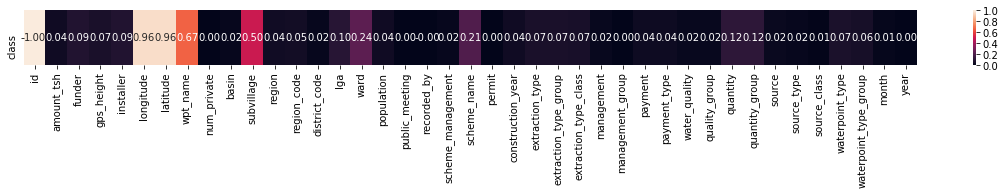

In [31]:
theilu = pd.DataFrame(index=['class'],columns=train.columns)
columns = train.columns
for j in range(0,len(columns)):
    u = theil_u(train_label['status_group'].tolist(),train[columns[j]].tolist())
    theilu.loc[:,columns[j]] = u
theilu.fillna(value=np.nan,inplace=True)
plt.figure(figsize=(20,1))
sns.heatmap(theilu,annot=True,fmt='.2f')
plt.show()

### remove less related columns from train and test sets

In [32]:
# delete_columns = ['region', 'recorded_by', 'extraction_type_class', 'management_group', 'payment', 'quality_group', 'source_type', 'source_class', 'waterpoint_type_group', 'payment_type', 'quantity_group']

# delete_columns = ['date_recorded','wpt_name','num_private','subvillage','lga','ward','recorded_by','extraction_type_group','extraction_type','scheme_name','management','waterpoint_type_group','source','source_class','quantity_group','quality_group','payment_type']

# for ele in delete_columns:
    
#     print(ele+": "+str(train[ele].isnull().values.any()))
#     train = train.drop([ele], axis=1)
#     test = test.drop([ele], axis=1)
    
# train.head()

### Label set encoding

In [33]:
data_classes = ['non functional', 'functional needs repair', 'functional']
encoded_label = dict(zip(data_classes, range(0,3,1)))
train_label['status_group'] = train_label['status_group'].map(encoded_label, na_action='ignore')


In [34]:
train_label.head()

,id,status_group
0,69572,2
1,8776,2
2,34310,2
3,67743,0
4,19728,2


### Do target encoding for non-numerical columns

In [35]:
from category_encoders import TargetEncoder
from category_encoders import LeaveOneOutEncoder


## create duplicate dataframe of train and test for catboost classification
train_ = train
test_ = test

train_encode = train_.sample(frac=0.25, random_state=42)
train_label_encode = train_label.loc[train_encode.index]

column_with_str = []
for col in col_except_id:
    if (type(train[col][0]) is str ):
        column_with_str.append(col)

# encoder = LeaveOneOutEncoder(sigma=0.05, random_state=42)
encoder = TargetEncoder()
    
encoder = encoder.fit(train_encode, train_label_encode['status_group'])
train_ = encoder.transform(train_)
test_ = encoder.transform(test_)

In [36]:
train_.head()

,id,amount_tsh,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,...,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,month,year
0,69572,6000.0,1.819444,1390,1.350000,34.938093,-9.856322,1.521277,0,1.380686,...,1.218915,1.383985,1.383985,1.340471,1.340471,1.155154,1.329718,1.245231,3,2011
1,8776,0.0,1.499994,1399,1.599946,34.698766,-2.147466,1.146919,0,1.086557,...,1.218915,1.148158,1.148158,1.334495,1.334495,1.195600,1.329718,1.245231,3,2013
2,34310,25.0,1.248521,686,1.467890,37.460664,-3.821329,1.163533,0,1.273863,...,1.218915,1.383985,1.383985,0.750000,0.750000,1.195600,0.857973,1.245231,2,2013
3,67743,0.0,1.200000,263,1.187500,38.486161,-11.155298,1.163533,0,0.820444,...,1.218915,0.059539,0.059539,1.052577,1.060822,1.155154,0.857973,1.245231,1,2013
4,19728,0.0,1.248521,0,1.285714,31.130847,-1.825359,1.092269,0,1.086557,...,1.218915,1.249487,1.249487,1.334495,1.334495,1.195600,1.329718,1.245231,7,2011


In [37]:
test_.head()

,id,amount_tsh,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,...,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,month,year
0,50785,0.0,1.705882,1996,1.650000,35.290799,-4.059696,1.163533,0,1.235535,...,1.218915,1.249487,1.249487,1.334495,1.334495,1.195600,0.325177,0.325177,2,2013
1,51630,0.0,0.993683,1569,1.193188,36.656709,-3.309214,1.163533,0,1.273863,...,1.218915,1.148158,1.148158,1.340471,1.340471,1.155154,1.329718,1.245231,2,2013
2,17168,0.0,0.993683,1567,1.193188,34.767863,-5.004344,1.163533,0,1.235535,...,1.218915,1.148158,1.148158,1.334495,1.334495,1.195600,0.325177,0.325177,2,2013
3,45559,0.0,0.413733,267,0.413733,38.058046,-9.418672,1.163533,0,0.820444,...,1.218915,0.059539,0.059539,1.038351,1.038351,1.155154,0.325177,0.325177,1,2013
4,49871,500.0,1.163533,1260,1.163533,35.006123,-10.950412,1.163533,0,0.820444,...,1.218915,1.383985,1.383985,1.340471,1.340471,1.155154,1.329718,1.245231,3,2013


### convert boolean value columns to 0's and 1's

In [38]:
train_.permit = train_.permit.astype(bool).astype(int)
train_.public_meeting = train_.public_meeting.astype(bool).astype(int)


### Perform onehot encoding for permit and public_meeting

In [39]:
train_ = pd.get_dummies(train_, columns = ['permit', 'public_meeting'])

In [40]:
train_.head()

,id,amount_tsh,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,...,source_type,source_class,waterpoint_type,waterpoint_type_group,month,year,permit_0,permit_1,public_meeting_0,public_meeting_1
0,69572,6000.0,1.819444,1390,1.350000,34.938093,-9.856322,1.521277,0,1.380686,...,1.340471,1.155154,1.329718,1.245231,3,2011,1,0,0,1
1,8776,0.0,1.499994,1399,1.599946,34.698766,-2.147466,1.146919,0,1.086557,...,1.334495,1.195600,1.329718,1.245231,3,2013,0,1,0,1
2,34310,25.0,1.248521,686,1.467890,37.460664,-3.821329,1.163533,0,1.273863,...,0.750000,1.195600,0.857973,1.245231,2,2013,0,1,0,1
3,67743,0.0,1.200000,263,1.187500,38.486161,-11.155298,1.163533,0,0.820444,...,1.060822,1.155154,0.857973,1.245231,1,2013,0,1,0,1
4,19728,0.0,1.248521,0,1.285714,31.130847,-1.825359,1.092269,0,1.086557,...,1.334495,1.195600,1.329718,1.245231,7,2011,0,1,0,1


### removing 'id' column from both train_ and train_label set

In [41]:
train_label = train_label.drop(['id'], axis=1)
train_ = train_.drop(['id'], axis=1)

### use SMOTE to handle imblanced train dataset

In [42]:
from imblearn.over_sampling import SMOTE

oversample = SMOTE(sampling_strategy = 'auto', n_jobs = -1, random_state=42)
X, y = oversample.fit_resample(train_, train_label)

### split train data set to X_train and X_test 

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, stratify= y)

### Normalization and classify using XGB classifier

In [44]:
model = XGBClassifier(objective = 'multi:softmax', booster = 'gbtree', nrounds = 'min.error.idx',
                      num_class = 3, maximize = False, eval_metric = 'merror', eta = .1,
                      max_depth = 16, colsample_bytree = .4, n_jobs = -1, random_state=42)

X_train = ((X_train-X_train.min())/(X_train.max()-X_train.min()))
X_test = ((X_test-X_test.min())/(X_test.max()-X_test.min()))

model.fit(X_train, y_train)

C:\Users\sh\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\sh\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[00:19:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "maximize", "nrounds" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.4, eta=0.1,
              eval_metric='merror', gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.100000001,
              max_delta_step=0, max_depth=16, maximize=False,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=-1, nrounds='min.error.idx', num_class=3,
              num_parallel_tree=1, objective='multi:softprob', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', ...)

### predict using X_test

In [45]:
predictions = model.predict(X_test)

### evaluate predictions

In [46]:
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 86.90%


### plot confusion matrix

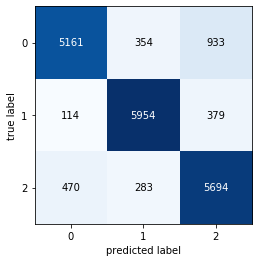

In [47]:
confusion_matrix = confusion_matrix(y_test['status_group'], predictions)
plot_confusion_matrix(confusion_matrix)
plt.show()

# y_test.head()
# predictions

### K-fold cross validation

In [48]:
cv = KFold(n_splits=10, random_state=42, shuffle=True)
scores = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
print('Accuracy: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

Accuracy: 0.875 (0.004)


### convert boolean values in public_meeting and permit of test set to 0's and 1's 

In [49]:
test_.permit = test_.permit.astype(bool).astype(int)
test_.public_meeting = test_.public_meeting.astype(bool).astype(int)

t = test_['id']
test_ = test_.drop(["id"], axis = 1)

### onehot encoding for permit and public_meeting of test_ set

In [50]:
test_ = pd.get_dummies(test_, columns = ['permit', 'public_meeting'])

In [51]:
test_.head()

,amount_tsh,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,...,source_type,source_class,waterpoint_type,waterpoint_type_group,month,year,permit_0,permit_1,public_meeting_0,public_meeting_1
0,0.0,1.705882,1996,1.650000,35.290799,-4.059696,1.163533,0,1.235535,0.312922,...,1.334495,1.195600,0.325177,0.325177,2,2013,0,1,0,1
1,0.0,0.993683,1569,1.193188,36.656709,-3.309214,1.163533,0,1.273863,1.163533,...,1.340471,1.155154,1.329718,1.245231,2,2013,0,1,0,1
2,0.0,0.993683,1567,1.193188,34.767863,-5.004344,1.163533,0,1.235535,1.163533,...,1.334495,1.195600,0.325177,0.325177,2,2013,0,1,0,1
3,0.0,0.413733,267,0.413733,38.058046,-9.418672,1.163533,0,0.820444,1.163533,...,1.038351,1.155154,0.325177,0.325177,1,2013,0,1,0,1
4,500.0,1.163533,1260,1.163533,35.006123,-10.950412,1.163533,0,0.820444,1.163533,...,1.340471,1.155154,1.329718,1.245231,3,2013,0,1,0,1


### predict values for  test dataset

In [52]:
test_=((test_- test_.min())/(test_.max() - test_.min()))
test_predictions = model.predict(test_)

### create csv file for output predictions 

In [53]:
test_predictions = test_predictions.tolist()
list_to_csv = []
t = list(t)
for i  in range(len(t)):
    if (test_predictions[i] == 0):
        list_to_csv.append([t[i], 'non functional'])
    elif (test_predictions[i] == 1):
        list_to_csv.append([t[i], 'functional needs repair'])
    else:
        list_to_csv.append([t[i], 'functional'])

to_csv = pd.DataFrame(list_to_csv, columns=['id', 'status_group'])
to_csv.to_csv('submission.csv', index = False)

In [54]:
print(len(to_csv.index))

14850


In [55]:
X_train.head()

,amount_tsh,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,...,source_type,source_class,waterpoint_type,waterpoint_type_group,month,year,permit_0,permit_1,public_meeting_0,public_meeting_1
27536,0.000000,0.496828,0.607692,0.596594,0.928801,0.719221,0.584546,0.0,0.809326,0.581164,...,0.750288,1.000000,0.000000,0.000000,0.181818,1.000000,0.0,1.0,1.0,0.0
8451,0.000029,0.472208,0.172028,0.416667,0.977284,0.088391,0.417542,0.0,0.000000,0.581164,...,0.526396,0.810243,0.000000,0.000000,0.090909,1.000000,1.0,0.0,0.0,1.0
19858,0.000000,0.573688,0.031469,0.596594,0.765364,0.866585,0.584546,0.0,0.474996,0.723741,...,1.000000,0.810243,0.822250,0.753094,0.545455,0.818182,0.0,1.0,0.0,1.0
43826,0.001429,0.573322,0.131469,0.596594,0.904798,0.304792,0.584546,0.0,0.905694,0.887358,...,0.488340,0.810243,0.782177,0.782177,0.181818,0.818182,0.0,1.0,0.0,1.0
10640,0.000286,0.389173,0.417483,0.311502,0.736491,0.598537,0.584546,0.0,0.419850,0.581164,...,0.750288,1.000000,0.436111,0.753094,0.000000,1.000000,0.0,1.0,0.0,1.0


In [56]:
X_test.head()


,amount_tsh,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,...,source_type,source_class,waterpoint_type,waterpoint_type_group,month,year,permit_0,permit_1,public_meeting_0,public_meeting_1
21109,0.0,0.573688,0.022768,0.495781,0.816415,0.209323,0.584546,0.0,1.000000,0.803063,...,0.488340,0.810243,0.782177,0.782177,0.272727,0.777778,1.0,0.0,0.0,1.0
72044,0.0,0.496828,0.022768,0.596594,0.833002,0.224410,0.323348,0.0,1.000000,0.644278,...,1.000000,0.810243,0.822250,0.753094,0.636364,0.777778,0.0,1.0,0.0,1.0
20378,0.0,0.741065,0.022768,0.589393,0.845697,0.674334,0.584546,0.0,0.740913,0.950074,...,0.526396,0.810243,0.000000,0.000000,0.818182,0.888889,0.0,1.0,0.0,1.0
26537,0.0,0.719001,0.022768,0.596594,0.831837,0.751305,0.584546,0.0,0.474996,0.486218,...,0.488340,0.810243,0.782177,0.782177,0.181818,1.000000,1.0,0.0,0.0,1.0
49948,0.0,0.166784,0.487170,0.166806,0.914684,0.712880,0.584546,0.0,0.809326,0.599422,...,0.750288,1.000000,0.822250,0.753094,0.545455,1.000000,0.0,1.0,0.0,1.0


### CatBoost classification

In [57]:
cat_features = []
for ele in train.columns:
    if(type(train[ele][0]) is str):
        cat_features.append(ele)

In [58]:
train.permit = train.permit.astype(bool).astype(int)
train.public_meeting = train.public_meeting.astype(bool).astype(int)
train = pd.get_dummies(train, columns = ['permit', 'public_meeting'])

test.permit = test.permit.astype(bool).astype(int)
test.public_meeting = test.public_meeting.astype(bool).astype(int)
test = pd.get_dummies(test, columns = ['permit', 'public_meeting'])

In [59]:
# train_label = train_label.drop(['id'], axis=1)
train = train.drop(['id'], axis=1)


t = test['id']
test = test.drop(["id"], axis = 1)


In [60]:
X_train_catboost, X_test_catboost, y_train_catboost, y_test_catboost = train_test_split(train,train_label, test_size=0.2, stratify= train_label)


In [61]:
from catboost import CatBoostClassifier

clf = CatBoostClassifier(
     max_ctr_complexity=5,
     task_type = 'CPU',
    iterations=10000,
    eval_metric='AUC',
    od_type='Iter',
    od_wait=500,
    cat_features = cat_features,
    verbose=False
    
)


clf.fit(X_train_catboost, y_train_catboost, 
        cat_features=cat_features, 
        eval_set=(X_test_catboost, y_test_catboost), 
        verbose=False
)

In [62]:
pred = clf.predict(data=X_test_catboost)

In [63]:
accuracy = accuracy_score(y_test_catboost, pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 81.21%


In [64]:
testpredictions = clf.predict(test)
# train.head()

In [65]:
test_predictions = testpredictions.tolist()
list_to_csv = []
t = list(t)
for i  in range(len(t)):
    if (test_predictions[i] == 0):
        list_to_csv.append([t[i], 'non functional'])
    elif (test_predictions[i] == 1):
        list_to_csv.append([t[i], 'functional needs repair'])
    else:
        list_to_csv.append([t[i], 'functional'])

to_csv = pd.DataFrame(list_to_csv, columns=['id', 'status_group'])
to_csv.to_csv('submission_catboost.csv', index = False)

In [66]:
train_label.head()

,status_group
0,2
1,2
2,2
3,0
4,2
